In [1]:
import json

import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [2]:
with open('data/homomorphism_counts/MUTAG_full_kernel_max_20_run1.homson') as f:
   data_run1 = json.load(f)

with open('data/homomorphism_counts/MUTAG_full_kernel_max_20_run2.homson') as f:
   data_run2 = json.load(f)

# To extract the homomorphism counts for each of the embeddings
hom_counts_list_run1 = np.array([element['counts'] for element in data_run1['data']], dtype = 'float')
hom_counts_list_run2 = np.array([element['counts'] for element in data_run2['data']], dtype = 'float')

In [3]:
def plot_matrix_runs(matrix_run1, matrix_run2, num_elements):

    cmap = plt.cm.get_cmap('viridis')

    # Set up subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Plot matrix_run1
    plt1 = axs[0].imshow(matrix_run1[0:num_elements, 0:num_elements], cmap=cmap)
    axs[0].set_title('Matrix Run 1')

    # Plot matrix_run2
    plt2 = axs[1].imshow(matrix_run2[0:num_elements, 0:num_elements], cmap=cmap)
    axs[1].set_title('Matrix Run 2')

    # Create a single color bar for both subplots
    cbar = fig.colorbar(plt1, ax=axs, shrink=0.6, label='Color scale')

    # Update the color limits based on the data in both matrices
    plt1.set_clim(vmin=min(matrix_run1.min(), matrix_run2.min()), vmax=max(matrix_run1.max(), matrix_run2.max()))
    plt2.set_clim(vmin=min(matrix_run1.min(), matrix_run2.min()), vmax=max(matrix_run1.max(), matrix_run2.max()))

    plt.show()

/var/folders/tv/ysw0jsvs2t331mtk7hdh35kc0000gn/T/ipykernel_3524/1182788070.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


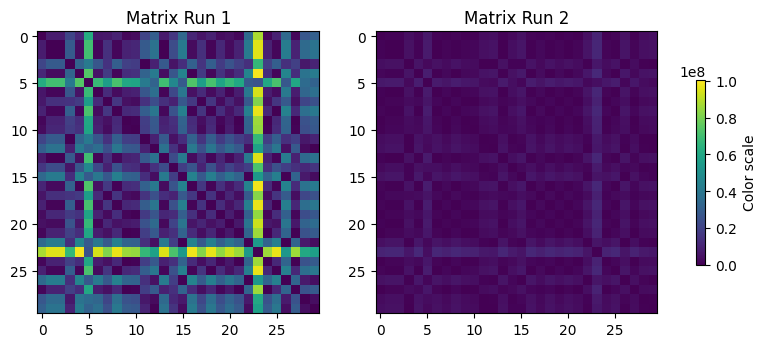

In [4]:
L1_run1 = cdist(hom_counts_list_run1, hom_counts_list_run1, metric='cityblock')
L1_run2 = cdist(hom_counts_list_run2, hom_counts_list_run2, metric='cityblock')
plot_matrix_runs(L1_run1, L1_run2, num_elements=30) # We can see some inconsitent scales among different runs

In [5]:
int((np.count_nonzero(L1_run1 == 0) - 188)/2) # There are this number of graphs which have distance 0 between themselves 

87

In [6]:
# We can avoid this issue by rescaling the output distance
hom_counts_list_run1[0] # Homomorphism count vector corresponding to the first one
# Either rescale the final y output to be in [0,1]
# Rescale the original homomorphism counts vectors so that they like sum to 1 (using something like a softmax) -> Maybe problematic cause small patterns may appear a lot of times more than lager patters

array([1.7000000e+01, 3.8000000e+01, 9.2000000e+01, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 3.4960000e+03,
       1.4433918e+07, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00])

### Try to see if GNN picks up something interesting

In [7]:
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing, global_mean_pool, GCNConv
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.loader import DataLoader

from running_functions import training_loop

In [8]:
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
def some_transform(graph: Data) -> Data:
    feature_dimension = graph.x.shape[1]
    feature = torch.ones((1, feature_dimension))

    graph.extra_feature = feature

    return graph

In [11]:
def number_of_neighbours(graph):
    """
    Assuming that there are no disconnected nodes which do not appear in edge_index, this modifies
     the features of each node to only be one vector containing its number of neighbours
    """
    counts = graph.edge_index[0].unique(return_counts=True)[1].reshape(-1, 1)
    if len(counts) == graph.x.shape[0]:
        graph.x = counts
        return graph
    print(f"The input graph contains some unconnected node, this pre-transform can't work with it")
    raise TypeError()

In [12]:
dataset = TUDataset(root='/tmp/MUTAG_transformed', name='MUTAG', pre_transform=number_of_neighbours) 

In [13]:
dataset[0]['x'].shape[0]

17

In [14]:
# Check that they are in the same order as the dataset
for i in range(len(dataset)):
    if (dataset[i]['x'].shape[0] != data_run1['data'][i]['vertices']):
        print(f"The {i}-th observation is different")
        print(dataset[i]['x'].shape[0])
        print(data_run1['data'][i]['vertices'])

In [15]:
# Now we split the dataset into training and test validation set (see if include test later)
# For now we ignore shuffling, will do it later (I know not good practice but have to map each homcount to the node)
train_dataset = dataset[:100]
val_dataset = dataset[100:]

In [16]:
class PairData(Data):
    def __inc__(self, key, value, *args, **kwargs):
        if key == 'edge_index_1':
            return self.x_1.size(0)
        if key == 'edge_index_2':
            return self.x_2.size(0)
        return super().__inc__(key, value, *args, **kwargs)

In [17]:
# Construct all pairs of graphs using PairData object for both the training and validation set.
distance_matrix = L1_run1

train_data_list = []
for ind1, graph1 in enumerate(train_dataset):
    for ind2, graph2 in enumerate(train_dataset[ind1+1:]):
        ind2 += (ind1 + 1)
        train_data_list.append(PairData(x_1=graph1.x, edge_index_1=graph1.edge_index,
                            x_2=graph2.x, edge_index_2=graph2.edge_index,
                            distance = float(distance_matrix[ind1, ind2])).to(device))   

val_data_list = []
for ind1, graph1 in enumerate(val_dataset):
    for ind2, graph2 in enumerate(val_dataset[ind1+1:]):
        ind2 += (ind1 + 1)
        val_data_list.append(PairData(x_1=graph1.x, edge_index_1=graph1.edge_index,
                            x_2=graph2.x, edge_index_2=graph2.edge_index,
                            distance = float(distance_matrix[ind1 + len(train_dataset), ind2 + len(train_dataset)])).to(device))   

In [18]:
batch_size = 32
train_loader = DataLoader(train_data_list, batch_size=batch_size, follow_batch=['x_1', 'x_2'], shuffle=True)
val_loader = DataLoader(val_data_list, batch_size=batch_size, follow_batch=['x_1', 'x_2'], shuffle=False)
for step, data in enumerate(train_loader):
    print(f'Batch {step + 1}:')
    data = data.to(device)
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print(data.distance)
    print()
    break # Only print 1

Batch 1:
Number of graphs in the current batch: 32
PairDataBatch(x_1=[584, 1], x_1_batch=[584], x_1_ptr=[33], edge_index_1=[2, 1312], x_2=[605, 1], x_2_batch=[605], x_2_ptr=[33], edge_index_2=[2, 1364], distance=[32])
tensor([ 2940360., 19103076., 35181284., 93813168., 27996164., 65383388.,
        27813892., 43860416., 41741476., 23243832.,  3718732., 12026645.,
         3525624., 42708172.,  5093639., 44426348., 42637760., 25338860.,
        50770924.,  5276807., 32545794., 25436592., 28827062., 23751490.,
        52397140., 41119048.,  3607279., 35735448., 10494140.,  6280218.,
         9231197., 47012432.])



In [19]:
data['distance']

tensor([ 2940360., 19103076., 35181284., 93813168., 27996164., 65383388.,
        27813892., 43860416., 41741476., 23243832.,  3718732., 12026645.,
         3525624., 42708172.,  5093639., 44426348., 42637760., 25338860.,
        50770924.,  5276807., 32545794., 25436592., 28827062., 23751490.,
        52397140., 41119048.,  3607279., 35735448., 10494140.,  6280218.,
         9231197., 47012432.])

In [35]:
class GCN_pairs(torch.nn.Module):
    """
    Takes as input a pair of graphs which are both fed through 3 convolutional layers each followed by an activation function
    3 graph convolutional layers (Welling) that share parameters
    """
    def __init__(self, input_features, hidden_channels, output_embeddings, name):
        super(GCN_pairs, self).__init__()
        self.conv1 = GCNConv(input_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, output_embeddings)
        self.pdist = torch.nn.PairwiseDistance(p=1)
        self.name = name


    def forward(self, x1, edge_index1, batch1, x2, edge_index2, batch2): # Need a way to extract these from dataloader
        # 1. Obtain node embeddings for graph 1
        x1 = self.conv1(x1, edge_index1)
        x1 = x1.relu()
        x1 = self.conv2(x1, edge_index1)
        x1 = x1.relu()
        x1 = self.conv3(x1, edge_index1)
        # 2. Readout layer
        x1 = global_mean_pool(x1, batch1)  # [batch_size, hidden_channels]
        # 3. Apply a final linear transformation on the aggregated embedding
        x1 = torch.nn.functional.dropout(x1, p=0.5, training=self.training)
        x1 = self.lin(x1)

        # 1. Obtain node embeddings for graph 2
        x2 = self.conv1(x2, edge_index2)
        x2 = x2.relu()
        x2 = self.conv2(x2, edge_index2)
        x2 = x2.relu()
        x2 = self.conv3(x2, edge_index2)
        # 2. Readout layer
        x2 = global_mean_pool(x2, batch2)  # [batch_size, hidden_channels]
        # 3. Apply a final linear transformation on the aggregated embedding
        x2 = torch.nn.functional.dropout(x2, p=0.5, training=self.training)
        x2 = self.lin(x2)

        dist = self.pdist(x1, x2) # p = 1 is the manhattan distance
        return dist
    
    def save(self):
        """
        Saves the model state dictionary in models folder
        """
        path = 'models/' + self.name + '.pt'
        torch.save(model.state_dict(), path)

In [36]:
model = GCN_pairs(input_features=dataset.num_node_features, hidden_channels=64, output_embeddings=300, name='GCN3').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()
print(model)

GCN_pairs(
  (conv1): GCNConv(1, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=300, bias=True)
  (pdist): PairwiseDistance()
)


In [37]:
training_loop(model, train_loader, optimizer, criterion, val_loader, epoch_number=20)

Epoch: 10 | Time for 10 epochs: 0m 22s
	Train Loss: 388445316584401.750
	 Val. Loss: 804093509780548.250
Epoch: 20 | Time for 10 epochs: 0m 26s
	Train Loss: 387710308266803.188
	 Val. Loss: 789317656825036.750


## TO DO NOW:
- Try different distances and consider standardization of some sort, otherwise different runs have very different results.

## Inference step

In [38]:
model = GCN_pairs(input_features=dataset.num_node_features, hidden_channels=64, output_embeddings=300, name='GCN3').to(device)
model.load_state_dict(torch.load("models/GCN3.pt"))

<All keys matched successfully>

In [39]:
# Consider the results on the validation set.
model

GCN_pairs(
  (conv1): GCNConv(1, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=300, bias=True)
  (pdist): PairwiseDistance()
)

In [40]:
def score(model, loader):
    """
    Given a (pre-trained) model and a dataloader, 
    It returns:
        - y: the true values of the regressor
        - predict: the predicted values according to the model
    """
        
    y = torch.Tensor()
    predictions = torch.Tensor()

    model.eval()
    with torch.no_grad():
        # The remaining part is the same with the difference of not using the optimizer to backpropagation
        for batch in val_loader:
            y = torch.cat((y, batch['distance']))
            preds = model(batch.x_1.float(), batch.edge_index_1, batch.x_1_batch, 
                                    batch.x_2.float(), batch.edge_index_2, batch.x_2_batch)
            predictions = torch.cat((predictions, preds))
    return y, predictions

In [41]:
y, predictions = score(model, val_loader)

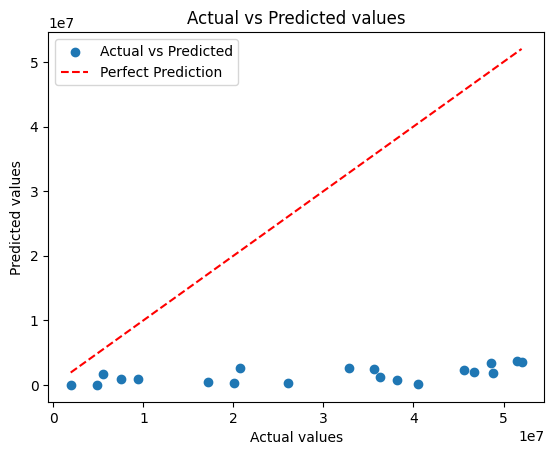

In [42]:
y_array = y.numpy()
predictions_array = predictions.numpy()

y_array = y_array[0:20]
predictions_array = predictions_array[0:20]

# Plot the actual vs predicted values
plt.scatter(y_array, predictions_array, label='Actual vs Predicted')
plt.plot([min(y_array), max(y_array)], [min(y_array), max(y_array)], '--', color='red', label='Perfect Prediction')

# Customize the plot
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted values')
plt.legend()

# Show the plot
plt.show()